In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns

from ipywidgets import interact, SelectionSlider, IntSlider

In [2]:
import metadata_util
spec_names = metadata_util.read_spec_names()
phy_names = metadata_util.get_phy_names()
jval_names = metadata_util.read_jval_names()

In [3]:
import sys
sys.path.append("../../GEOSChem/KPP4GC/GC_12_Standard/") # dirty fix to allow importing
import kpp4py

In [4]:
ds = xr.open_dataset('./KPP_fields_100.nc')
ds.coords['nspec'] = spec_names
ds.coords['nphotol'] = jval_names
ds.coords['nphy'] = phy_names
ds

<xarray.Dataset>
Dimensions:   (lat: 46, lev: 72, lon: 72, nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
  * nspec     (nspec) <U8 'CH2I2' 'CH2ICl' 'CH2IBr' 'AERI' 'CO2' 'INDIOL' ...
  * nphotol   (nphotol) object '1/O2/O2' '2/O3/O3' '3/O3/O3(1D)' '4/H2O/H2O' ...
  * nphy      (nphy) <U6 'TEMP' 'PRESS' 'NUMDEN' 'H2O'
Dimensions without coordinates: lat, lev, lon, nreact
Data variables:
    C_before  (lev, lat, lon, nspec) float64 ...
    C_after   (lev, lat, lon, nspec) float64 ...
    PHOTOL    (lev, lat, lon, nphotol) float64 ...
    PHY       (lev, lat, lon, nphy) float64 ...
    RCONST    (lev, lat, lon, nreact) float64 ...

In [5]:
ds_mean = ds.mean(dim=['lev', 'lat', 'lon'])
ds_mean

<xarray.Dataset>
Dimensions:   (nphotol: 130, nphy: 4, nreact: 725, nspec: 240)
Coordinates:
  * nspec     (nspec) <U8 'CH2I2' 'CH2ICl' 'CH2IBr' 'AERI' 'CO2' 'INDIOL' ...
  * nphotol   (nphotol) object '1/O2/O2' '2/O3/O3' '3/O3/O3(1D)' '4/H2O/H2O' ...
  * nphy      (nphy) <U6 'TEMP' 'PRESS' 'NUMDEN' 'H2O'
Dimensions without coordinates: nreact
Data variables:
    C_before  (nspec) float64 1.803e+04 2.358e+05 3.319e+04 9.041e+05 0.0 ...
    C_after   (nspec) float64 1.358e+04 2.232e+05 2.919e+04 9.041e+05 ...
    PHOTOL    (nphotol) float64 2.057e-11 0.0002036 0.0001275 0.0 0.0 ...
    PHY       (nphy) float64 200.6 296.9 8.097e+18 5.378e+16
    RCONST    (nreact) float64 6.37e-15 3.152e-14 1.107e-15 7.199e-18 ...

# Choose reference point

In [6]:
ref_c_before = ds_mean['C_before'].values
ref_phy = ds_mean['PHY'].values
ref_photol = ds_mean['PHOTOL'].values

ref_c_before.shape, ref_phy.shape, ref_photol.shape

((240,), (4,), (130,))

In [7]:
ref_features = np.r_[ref_c_before, ref_phy, ref_photol]
ref_features.shape

(374,)

In [8]:
ref_c_after = kpp4py.onestep(ref_c_before, ref_phy, ref_photol).ravel()
ref_c_after.shape

(240,)

In [9]:
n_c = ref_c_before.shape[0]
n_phy = ref_phy.shape[0]
n_jv = ref_photol.shape[0]

n_features = n_c + n_phy + n_jv
n_features

374

# Change a particular input variable

In [10]:
var = 'O3'
idx = spec_names.index(var)
idx

230

In [11]:
original_sample = ds['C_before'].sel(nspec=var).values.ravel()
original_sample.shape

(238464,)

(<matplotlib.lines.Line2D at 0x1c208060b8>,)

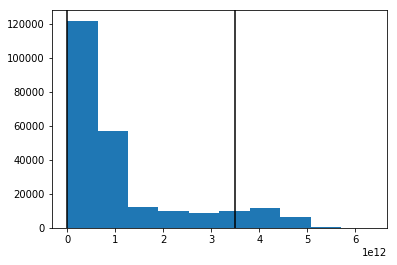

In [12]:
q0 = np.quantile(original_sample, 0.1)
q1 = np.quantile(original_sample, 0.9)
plt.hist(original_sample)
plt.axvline(q0, c='k'); plt.axvline(q1, c='k'),

In [13]:
# change this particular feature
n_grid = 20

grid_features = np.empty([n_grid, n_features])
grid_features[:] = ref_features

grid_x = np.linspace(q0, q1, n_grid)
grid_features[:,idx] = grid_x

In [14]:
def solve_kpp(features):
    c_before = features[:,0:n_c]
    phy = features[:,n_c:n_c+n_phy]
    jvals = features[:,n_c+n_phy:]
    
    c_after = kpp4py.onestep(c_before.T, 
                             phy.T, 
                             jvals.T).T
    return c_after

In [15]:
grid_result = solve_kpp(grid_features)
grid_result.shape

(20, 240)

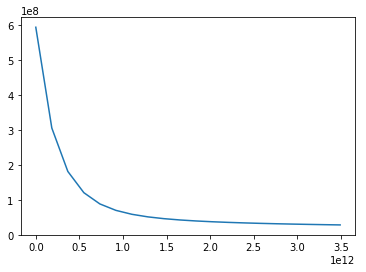

In [16]:
idy = spec_names.index('NO')

plt.plot(grid_x, grid_result[:,idy])

In [17]:
@interact(var=SelectionSlider(options=spec_names))
def plot_response(var):
    idy = spec_names.index(var)
    plt.plot(grid_x, grid_result[:,idy])
    plt.ylabel(var)

interactive(children=(SelectionSlider(description='var', options=('CH2I2', 'CH2ICl', 'CH2IBr', 'AERI', 'CO2', …

# Fitting

In [18]:
import torch
torch.__version__

'0.4.1'